# Model training

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras import layers
from keras import backend as K
import pickle as pkl
from tensorflow.keras.optimizers import SGD, Adam
import itertools
import random
import time
from datetime import datetime
from sklearn import metrics
import seaborn as sn

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

INTERM_DIR = '../compiled_data'
TRAIN_DATA_PATH = os.path.join(INTERM_DIR, 'train_data.pkl')
MODEL_DIR = './models'

In [2]:
from models import build_tcn, build_lstm

class PerformTraining:
    
    """
    This class performs the training of the desired model

    ...

    Attributes
    ----------
    seed : int
        the integer of the seed utilised for reproducibility 
    TRAIN_DATA_PATH : str
            a string indicating the directory containing preprocessed data split
            into train, val and test sets
    INTERM_DATA_DIR : str
        a string indicating the directory containing intermediate computed data
    MODEL_DIR : str
        a string indicating the directory containing created models
    model_gs_params : dict
        a dictionary of preprocessing parameters
        
    Methods
    -------
    reproducible_results()
        Sets seed and ensures all deterministic operations are reproducible
    retrieve_data()
        Retrieves the data given the data directory and folders
    prepare_data(preprocessing_params, tuning=True):
        Combines the preprocessing methods and splits the data for training 
    """

    def __init__(self, epochs, TRAIN_DATA_PATH, INTERM_DATA_DIR, MODEL_DIR, model_gs_params, model_type, flush, save_plot):
        
        """
        Parameters
        ----------
        TRAIN_DATA_PATH : str
            a string indicating the directory containing preprocessed data split
            into train, val and test sets
        INTERM_DATA_DIR : str
            a string indicating the directory containing intermediate computed data
        MODEL_DIR : str
            a string indicating the directory containing created models
        model_gs_params : list of lists
            a list of lists containing the parameters for model training
        """

        self.seed = 7

        self.TRAIN_DATA_PATH = TRAIN_DATA_PATH
        self.INTERM_DATA_DIR = INTERM_DATA_DIR
        self.MODEL_DIR = MODEL_DIR
        self.model_gs_params = model_gs_params
        self.max_epochs = epochs
        self.model_type = model_type
        self.flush = flush
        self.save_plot = save_plot
        
        with open(TRAIN_DATA_PATH, 'rb') as f:
            self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test = pkl.load(f)
            
        # random shuffle dataset
        p = np.random.permutation(len(self.X_train))
        self.X_train, self.y_train = self.X_train[p], self.y_train[p]
            
        print(f"The class distributions in the training set are: {np.unique(self.y_train, return_counts=True)}")
        print(f"The class distributions in the validation set are: {np.unique(self.y_val, return_counts=True)}")
        print(f"The class distributions in the test set are: {np.unique(self.y_test, return_counts=True)}")

        self.y_train, self.y_val, self.y_test = keras.utils.to_categorical(self.y_train), keras.utils.to_categorical(self.y_val), keras.utils.to_categorical(self.y_test)
        
        self.reproducible_results()
        #self.X_train, self.X_val, self.X_test = self.X_train[:,8:,:], self.X_val[:,8:,:], self.X_test[:,8:,:]
#         sample_mean = np.mean(self.X_train, axis=0)
#         sample_std = np.mean(self.X_train, axis=0)
#         self.X_train = (self.X_train - sample_mean) / sample_std
#         self.X_val = (self.X_val - sample_mean) / sample_std
#         self.X_test = (self.X_test - sample_mean) / sample_std
        
        if self.model_type == 'tcn':
            self.perform_gs_training(build_tcn, os.path.join(self.MODEL_DIR, 'tcn'))
            
        if self.model_type == 'lstm':
            self.perform_gs_training(build_lstm, os.path.join(self.MODEL_DIR, 'lstm'))

    def reproducible_results(self):

        """Obtain reproducible results with keras, source: https://stackoverflow.com/a/52897216"""

        # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
        os.environ['PYTHONHASHSEED'] = str(self.seed)

        # 2. Set the `python` built-in pseudo-random generator at a fixed value
        random.seed(self.seed)

        # 3. Set the `numpy` pseudo-random generator at a fixed value
        np.random.seed(self.seed)

        # 4. Set the `tensorflow` pseudo-random generator at a fixed value
        tf.compat.v1.set_random_seed(self.seed)

        # 5. Configure a new global `tensorflow` session
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        K.set_session(sess)

    def plot_confusion_matrix(self, confusion_matrix, title, save_plot_dir):
        """Plots a given confusion matrix and saves it

        Parameters
        ----------
        confusion_matrix : ndarray
            a numpy array of the confusion matrix
        title : str
            a string of the title name
        save_plot_dir : str
            a string of where to save the plot

        Returns
        -------
        (ndarray, ndarray)
            a tuple of the numpy arrays of the upsampled feature and label arrays
        """  
        # Plot confusion matrix
        labels = np.unique(self.y_train)
        df_cm = pd.DataFrame(confusion_matrix, index = [i for i in np.unique(self.y_train)], columns = [i for i in np.unique(self.y_train)])
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(title, ha="center")
        plt.xticks(np.arange(0.5, len(labels) + 0.5, 1), labels, rotation='horizontal')
        plt.yticks(np.arange(0.5, len(labels) + 0.5, 1), labels, rotation='horizontal')
        if save_plot_dir is not None: 
            plt.savefig(f'{save_plot_dir}.pdf', bbox_inches='tight')
        plt.show()

        
    def model_param_setup(self, params):
        """Retrieve from a given ordered list the correct parameters depending on model type"""
        
        if self.model_type == 'tcn':

            model_params = {'n_layers' : params[0], 
                            'cnn_dropout_p' : params[1], 
                            'dense_dropout_p' : params[2], 
                            'activation' : params[3], 
                            'n_dense_layers' : params[4], 
                            'n_dense_neurons' : params[5], 
                            'batch_normalization' : params[6], 
                            'batch_size' : params[7],
                            'optimizer' : params[8]}

        if self.model_type == 'lstm':

            model_params = {'n_layers' : params[0], 
                            'batch_size' : params[1],
                            'lstm_neurons' : params[2], 
                            'n_dense_neurons' : params[3], 
                            'dropout' : params[4], 
                            'activation' : params[5],
                            'optimizer' : params[6]}

        return model_params    
    
    
    def perform_gs_training(self, model_fn, checkpoint_filepath):

        """Performs cross-validated grid search training for selected model function

        Parameters
        ----------
        model_fn : function
            a function which creates a keras compiled model
        checkpoint_filepath : str
            a string indicating where to save the plots and grid search results 
            of the cross-validated grid search
        Returns
        -------
        pandas.DataFrame
            a pandas dataframe containing the results of the grid search, 
            specifically average performance for given hyperparameters
        """  

        pkl_name = os.path.join(checkpoint_filepath, 'gs_res.pkl')
        if os.path.isfile(pkl_name) and self.flush==False:
            with open(pkl_name, 'rb') as f:
                gs_res = pkl.load(f)
        else: 
            gs_res = []

        for idx, params in enumerate(self.model_gs_params): 

            print("=================================================")
            print("Presenting Results for: %s/%s Hyperparameter Combination" % (idx+1, len(self.model_gs_params)))

            model_params = self.model_param_setup(params)
            print(model_params)

            batch_size = model_params['batch_size']

            # Create backlog for accuracy in each fold
            val_fold_accuracy = []
            test_fold_accuracy = []

            try:     

                # Prepare the training dataset
                train_dataset = tf.data.Dataset.from_tensor_slices((self.X_train, self.y_train))
                train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(batch_size)

                # Prepare the validation dataset
                val_dataset = tf.data.Dataset.from_tensor_slices((self.X_val, self.y_val))
                val_dataset = val_dataset.shuffle(buffer_size = 1024).batch(batch_size)
                
                if self.model_type == 'lstm':
                    # In stateful lstm, need to have full batches, i.e. a dataset size divisible by batch_size
                    rem_last_n_train = (self.X_train.shape[0] % batch_size)
                    if rem_last_n_train > 0:
                        self.X_train, self.y_train = self.X_train[:-rem_last_n_train], self.y_train[:-rem_last_n_train]

                    rem_last_n_val = (self.X_val.shape[0] % batch_size)
                    if rem_last_n_val > 0:
                        self.X_val, self.y_val = self.X_val[:-rem_last_n_val], self.y_val[:-rem_last_n_val]
                    
                    rem_last_n_test = (self.X_test.shape[0] % batch_size)
                    if rem_last_n_test > 0:
                        self.X_test, self.y_test = self.X_test[:-rem_last_n_test], self.y_test[:-rem_last_n_test]
                    
                model = model_fn(self.X_train, **model_params)

                # Create Tensorboard
                logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
                tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, update_freq='epoch', profile_batch=0)
                # Model Checkpoint Callback
                checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_filepath,'checkpoint'), save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
                # Early Stopping Callback
                early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 50)

                # Train the model
                training_history = model.fit(self.X_train, self.y_train, batch_size=batch_size, validation_data=(self.X_val, self.y_val),
                                             steps_per_epoch = self.X_train.shape[0] // batch_size if self.model_type == 'lstm' else None, 
                                             callbacks = [tensorboard_callback,
                                                          early_stopping_callback,
                                                          checkpoint_callback],
                                             epochs=self.max_epochs, verbose=1)
                

            except Exception as e: 
                print(e)

            try: 

                # Compute confusion matrix across validation folds, and the test set
                def compute_confusion_matrix(set_to_predict, true_values, model):
                    y_predicted = model.predict(set_to_predict)
                    class_pred = np.argmax(y_predicted,axis = 1)
                    class_true = np.argmax(true_values,axis = 1)
                    res = metrics.confusion_matrix(class_true, class_pred)
                    perc_acc = res / res.sum(axis=0)
                    return perc_acc

                test_accuracy = compute_confusion_matrix(self.X_test, self.y_test, model)
                val_accuracy = compute_confusion_matrix(self.X_val, self.y_val, model)
                
                def plot_roc(set_to_predict, true_values, model, title_prefix, save_plot_dir):
                    y_pred_keras = model.predict(set_to_predict)
                    class_true = np.argmax(true_values, axis = 1)
                    fpr_keras, tpr_keras, thresholds_keras = metrics.roc_curve(class_true, y_pred_keras[:,1])
                    auc_keras = metrics.auc(fpr_keras, tpr_keras)
                    
                    plt.figure()
                    lw = 2
                    plt.plot(fpr_keras, tpr_keras,
                        color="darkorange", lw=lw,
                        label="ROC curve (area = %0.2f)" % auc_keras,
                    )
                    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel("False Positive Rate")
                    plt.ylabel("True Positive Rate")
                    plt.title("%s ROC" % title_prefix)
                    plt.legend(loc="lower right")
                    if save_plot_dir is not None: 
                        plt.savefig(f'{save_plot_dir}.pdf', bbox_inches='tight')
                    plt.show()
                    
                    return auc_keras
                

                if self.save_plot == True: 
                    string_model_params = model_params
                    del string_model_params['optimizer']
                    string_model_params['learning_rate'] = K.eval(model.optimizer.lr)

                    string_model_params = [str(x) for x in [*string_model_params.values()]]
                    save_plot_dir = os.path.join(checkpoint_filepath, 'plots')
                    save_plot_val_dir = os.path.join(save_plot_dir, 'Val CM ' + ' '.join(string_model_params))
                    save_plot_test_dir = os.path.join(save_plot_dir, 'Test CM ' + ' '.join(string_model_params))
                else: 
                    save_plot_val_dir = None
                    save_plot_test_dir = None

                self.plot_confusion_matrix(test_accuracy, 'Validation Dataset Accuracy', save_plot_val_dir)    
                self.plot_confusion_matrix(val_accuracy, 'Test Validation Dataset Accuracy', save_plot_test_dir)
                
                test_roc = plot_roc(self.X_test, self.y_test, model, 'Test', save_plot_val_dir + 'ROC')
                val_roc = plot_roc(self.X_val, self.y_val, model, 'Validation', save_plot_test_dir + 'ROC')

                curr_gs_res = [model_params, self.model_type, test_accuracy.diagonal(), val_accuracy.diagonal(), test_roc, val_roc]
                gs_res.append(curr_gs_res)
                with open(pkl_name, 'wb') as f:
                    pkl.dump(gs_res, f)

            except Exception as e: 
                print(e)

        return gs_res



# TCN training

20 Hyperparameter combinations determined
The class distributions in the training set are: (array([0., 1.]), array([230, 279]))
The class distributions in the validation set are: (array([0., 1.]), array([49, 92]))
The class distributions in the test set are: (array([0., 1.]), array([30, 42]))
Presenting Results for: 1/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': None, 'dense_dropout_p': 0.2, 'activation': 'tanh', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f8c80bd6cd0>}
Epoch 1/2000
32/32 [==============================] - 1s 12ms/step - loss: 0.7064 - accuracy: 0.5226 - precision: 0.5226 - recall: 0.5226 - val_loss: 0.6762 - val_accuracy: 0.6525 - val_precision: 0.6525 - val_recall: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.5265 - precision: 0.5265 - recall: 0.5265 - val_loss: 0.6796 - val_accuracy: 0.6525

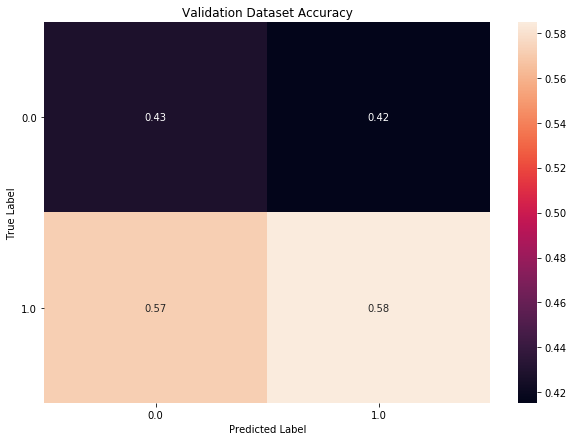

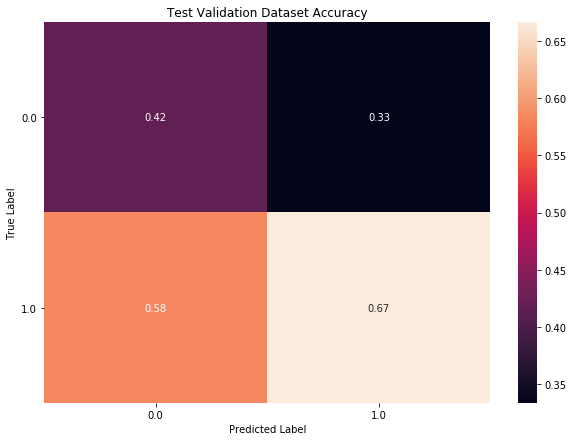

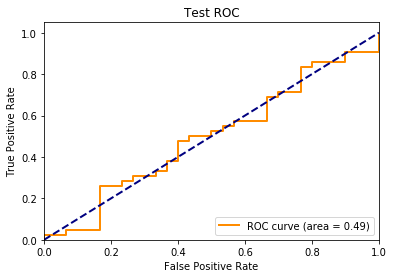

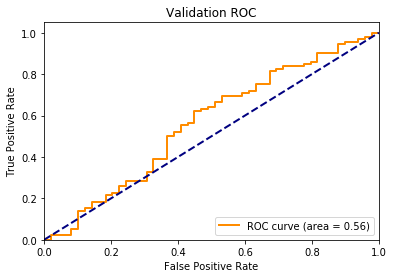

Presenting Results for: 2/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.2, 'dense_dropout_p': 0.5, 'activation': 'tanh', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 13ms/step - loss: 0.7234 - accuracy: 0.5363 - precision_1: 0.5363 - recall_1: 0.5363 - val_loss: 0.6929 - val_accuracy: 0.6028 - val_precision_1: 0.6028 - val_recall_1: 0.6028
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7310 - accuracy: 0.4853 - precision_1: 0.4853 - recall_1: 0.4853 - val_loss: 0.6914 - val_accuracy: 0.6525 - val_precision_1: 0.6525 - val_recall_1: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7160 - accuracy: 0.5088 - precision_1: 0.5088 - recall_1: 0.5088 - val_loss: 0.6893 - val_accuracy: 0.6525 - val_precision_1: 0.6525 - val_recall_

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


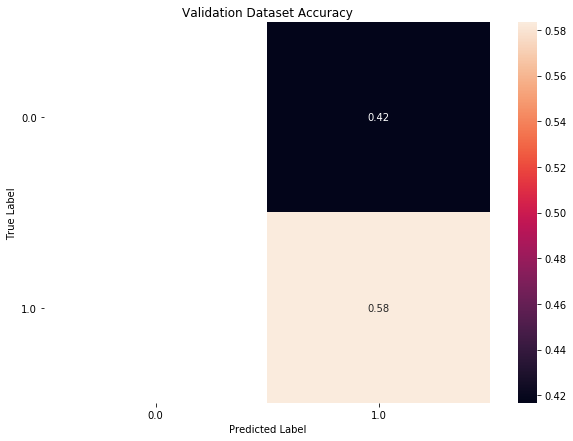

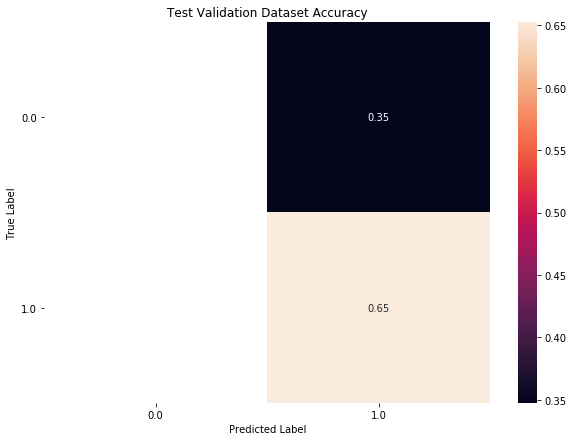

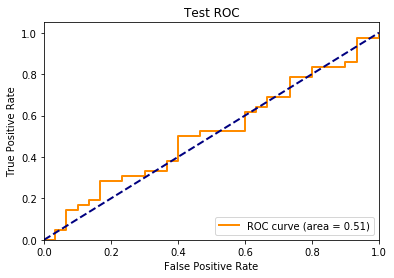

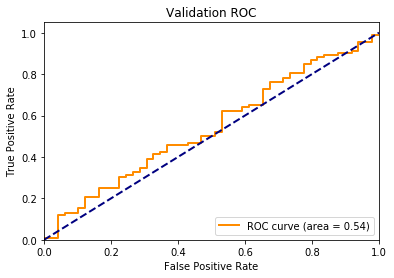

Presenting Results for: 3/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.5, 'dense_dropout_p': 0.2, 'activation': 'tanh', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 12ms/step - loss: 0.7138 - accuracy: 0.4833 - precision_2: 0.4833 - recall_2: 0.4833 - val_loss: 0.6963 - val_accuracy: 0.3475 - val_precision_2: 0.3475 - val_recall_2: 0.3475
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7104 - accuracy: 0.4676 - precision_2: 0.4676 - recall_2: 0.4676 - val_loss: 0.6972 - val_accuracy: 0.3475 - val_precision_2: 0.3475 - val_recall_2: 0.3475
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7152 - accuracy: 0.4833 - precision_2: 0.4833 - recall_2: 0.4833 - val_loss: 0.6981 - val_accuracy: 0.3475 - val_precision_2: 0.3475 - val_recall_

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


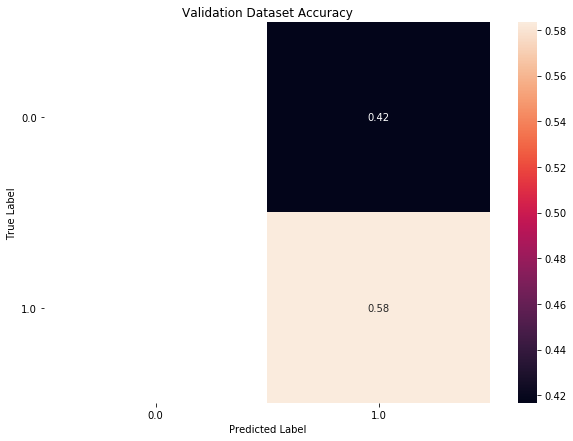

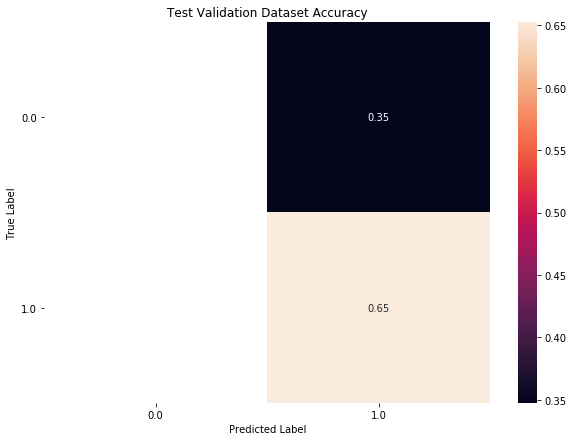

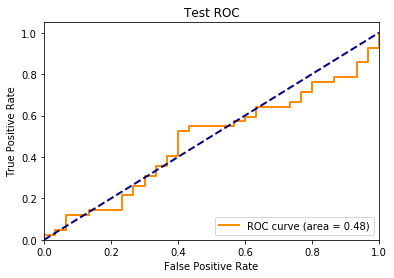

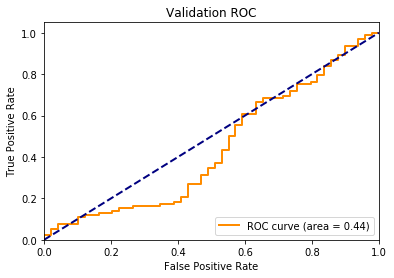

Presenting Results for: 4/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': None, 'dense_dropout_p': None, 'activation': 'relu', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 13ms/step - loss: 0.6950 - accuracy: 0.5422 - precision_3: 0.5422 - recall_3: 0.5422 - val_loss: 0.6915 - val_accuracy: 0.6525 - val_precision_3: 0.6525 - val_recall_3: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.5403 - precision_3: 0.5403 - recall_3: 0.5403 - val_loss: 0.6911 - val_accuracy: 0.6525 - val_precision_3: 0.6525 - val_recall_3: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.5462 - precision_3: 0.5462 - recall_3: 0.5462 - val_loss: 0.6908 - val_accuracy: 0.6525 - val_precision_3: 0.6525 - val_recal

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


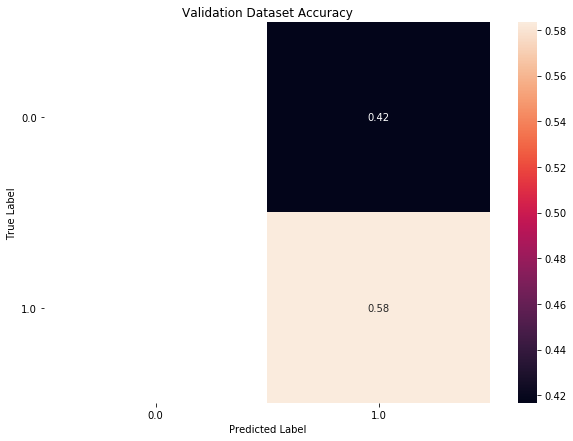

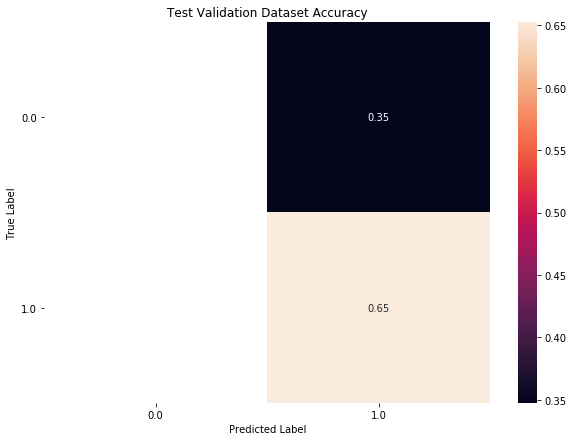

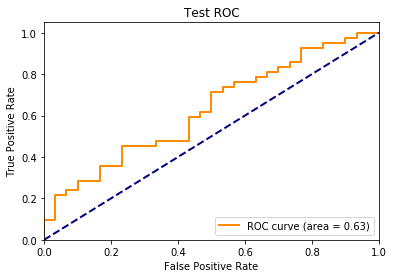

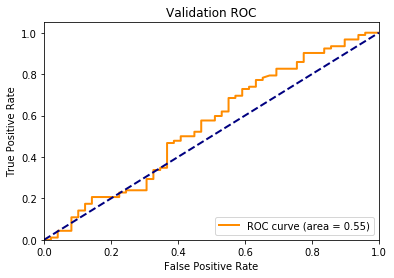

Presenting Results for: 5/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.5, 'dense_dropout_p': None, 'activation': 'relu', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.7141 - accuracy: 0.5206 - precision_4: 0.5206 - recall_4: 0.5206 - val_loss: 0.6895 - val_accuracy: 0.6525 - val_precision_4: 0.6525 - val_recall_4: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7109 - accuracy: 0.5363 - precision_4: 0.5363 - recall_4: 0.5363 - val_loss: 0.6904 - val_accuracy: 0.6525 - val_precision_4: 0.6525 - val_recall_4: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7067 - accuracy: 0.5305 - precision_4: 0.5305 - recall_4: 0.5305 - val_loss: 0.6902 - val_accuracy: 0.6525 - val_precision_4: 0.6525 - val_recall_

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


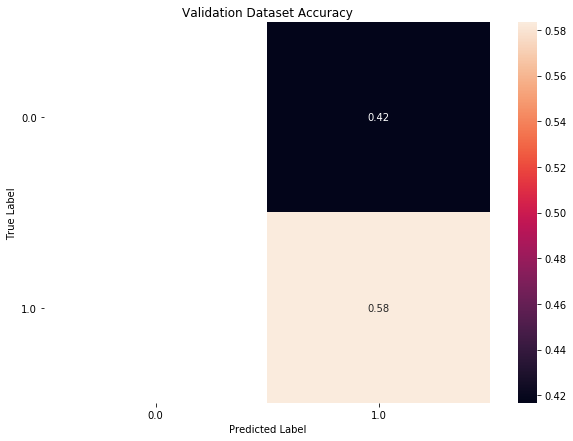

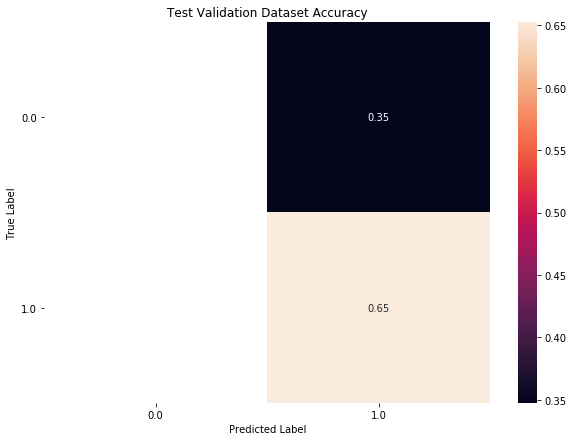

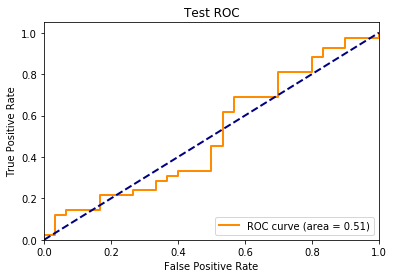

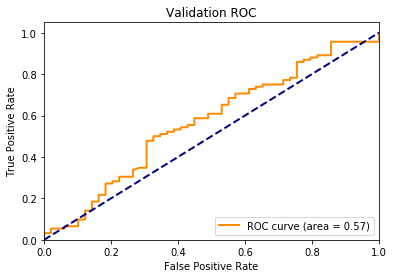

Presenting Results for: 6/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.2, 'dense_dropout_p': 0.5, 'activation': 'tanh', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f8c80bd6cd0>}
Epoch 1/2000
32/32 [==============================] - 1s 10ms/step - loss: 0.7242 - accuracy: 0.5167 - precision_5: 0.5167 - recall_5: 0.5167 - val_loss: 0.6810 - val_accuracy: 0.6525 - val_precision_5: 0.6525 - val_recall_5: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7068 - accuracy: 0.5187 - precision_5: 0.5187 - recall_5: 0.5187 - val_loss: 0.6730 - val_accuracy: 0.6525 - val_precision_5: 0.6525 - val_recall_5: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7142 - accuracy: 0.5147 - precision_5: 0.5147 - recall_5: 0.5147 - val_loss: 0.6726 - val_accuracy: 0.6525 - val_precision_5: 0.6525 - val_recall_5: 0.6525
E

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


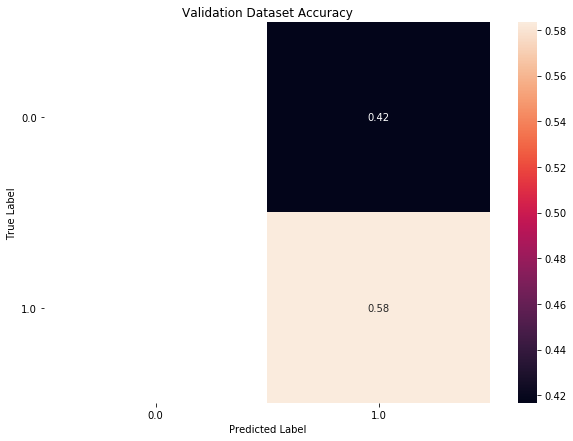

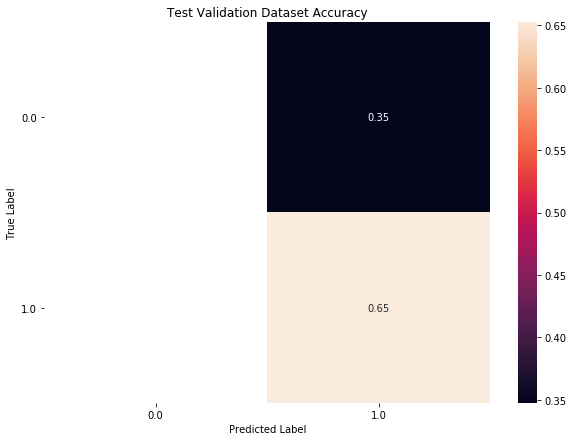

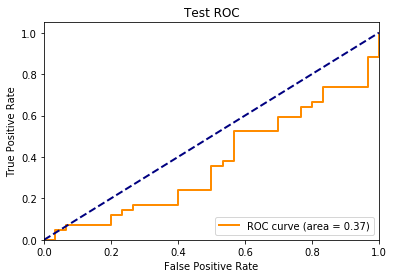

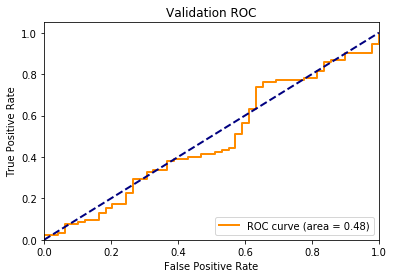

Presenting Results for: 7/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.2, 'dense_dropout_p': None, 'activation': 'relu', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f8c80bd6cd0>}
Epoch 1/2000
32/32 [==============================] - 1s 14ms/step - loss: 0.6988 - accuracy: 0.5305 - precision_6: 0.5305 - recall_6: 0.5305 - val_loss: 0.6852 - val_accuracy: 0.6525 - val_precision_6: 0.6525 - val_recall_6: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.6956 - accuracy: 0.5481 - precision_6: 0.5481 - recall_6: 0.5481 - val_loss: 0.6848 - val_accuracy: 0.6525 - val_precision_6: 0.6525 - val_recall_6: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.6903 - accuracy: 0.5305 - precision_6: 0.5305 - recall_6: 0.5305 - val_loss: 0.6803 - val_accuracy: 0.6525 - val_precision_6: 0.6525 - val_recall_6: 0.6525


/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


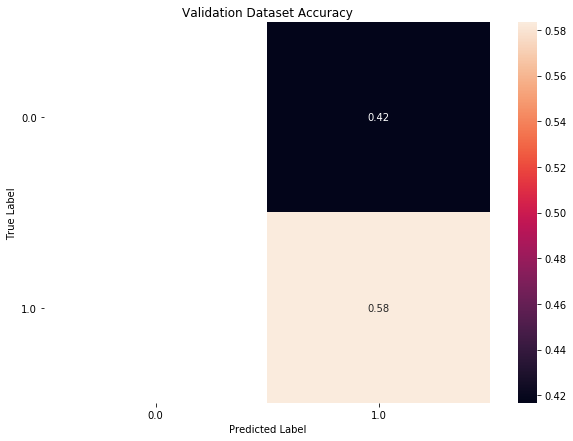

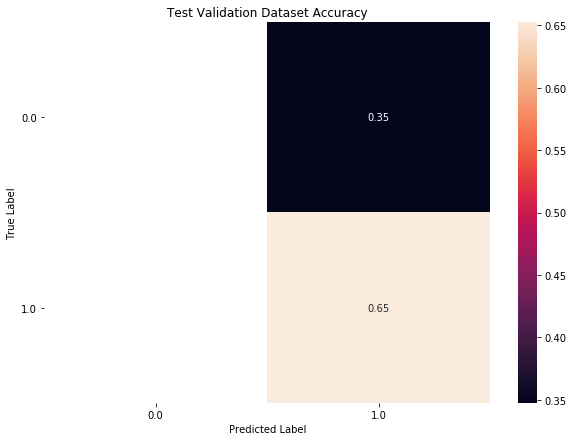

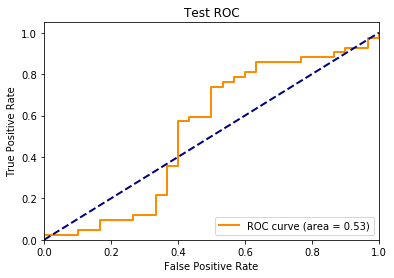

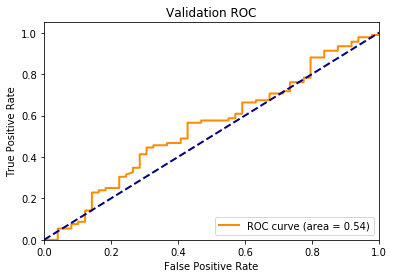

Presenting Results for: 8/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.5, 'dense_dropout_p': 0.2, 'activation': 'relu', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f8c80bd6cd0>}
Epoch 1/2000
32/32 [==============================] - 1s 10ms/step - loss: 0.7247 - accuracy: 0.5383 - precision_7: 0.5383 - recall_7: 0.5383 - val_loss: 0.6924 - val_accuracy: 0.6525 - val_precision_7: 0.6525 - val_recall_7: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7025 - accuracy: 0.5422 - precision_7: 0.5422 - recall_7: 0.5422 - val_loss: 0.6987 - val_accuracy: 0.3475 - val_precision_7: 0.3475 - val_recall_7: 0.3475
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.6987 - accuracy: 0.5324 - precision_7: 0.5324 - recall_7: 0.5324 - val_loss: 0.6946 - val_accuracy: 0.3475 - val_precision_7: 0.3475 - val_recall_7: 0.3475
E

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


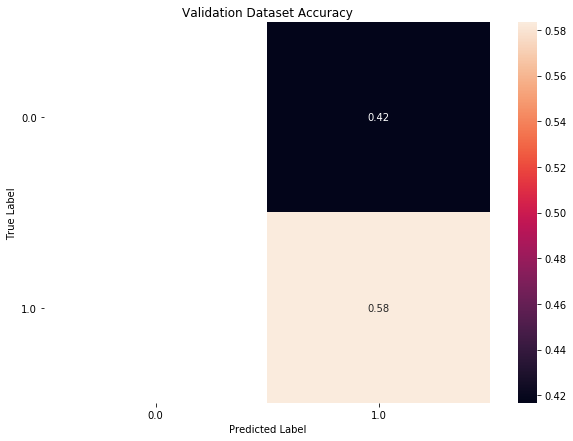

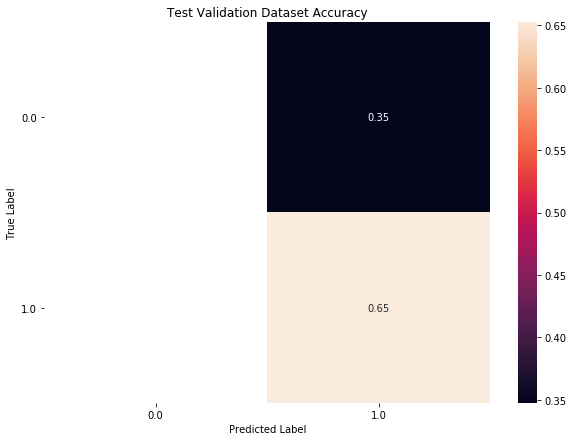

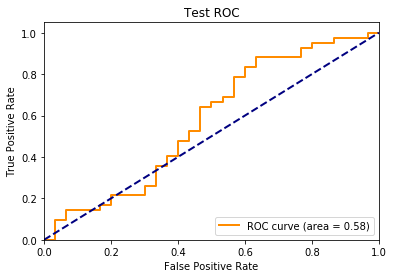

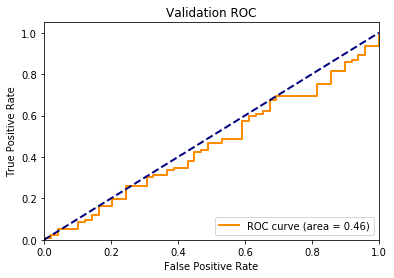

Presenting Results for: 9/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.5, 'dense_dropout_p': 0.5, 'activation': 'relu', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.7195 - accuracy: 0.5226 - precision_8: 0.5226 - recall_8: 0.5226 - val_loss: 0.6940 - val_accuracy: 0.3617 - val_precision_8: 0.3617 - val_recall_8: 0.3617
Epoch 2/2000
32/32 [==============================] - 0s 1ms/step - loss: 0.7195 - accuracy: 0.4833 - precision_8: 0.4833 - recall_8: 0.4833 - val_loss: 0.6932 - val_accuracy: 0.3759 - val_precision_8: 0.3759 - val_recall_8: 0.3759
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7211 - accuracy: 0.4912 - precision_8: 0.4912 - recall_8: 0.4912 - val_loss: 0.6925 - val_accuracy: 0.6525 - val_precision_8: 0.6525 - val_recall_8

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


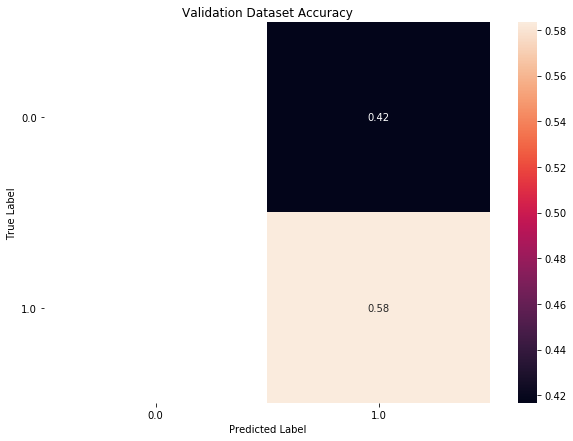

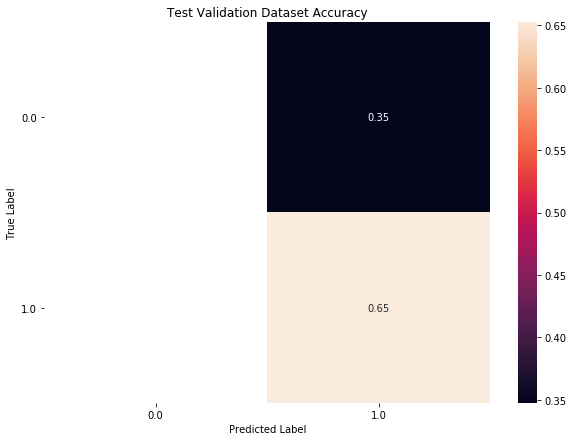

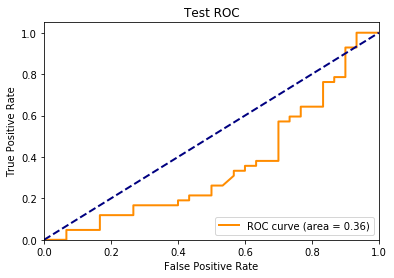

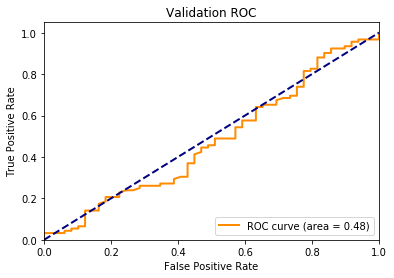

Presenting Results for: 10/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.2, 'dense_dropout_p': 0.5, 'activation': 'relu', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f8c80bd6cd0>}
Epoch 1/2000
32/32 [==============================] - 1s 10ms/step - loss: 0.7163 - accuracy: 0.5344 - precision_9: 0.5344 - recall_9: 0.5344 - val_loss: 0.6879 - val_accuracy: 0.6525 - val_precision_9: 0.6525 - val_recall_9: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7050 - accuracy: 0.5619 - precision_9: 0.5619 - recall_9: 0.5619 - val_loss: 0.6880 - val_accuracy: 0.6525 - val_precision_9: 0.6525 - val_recall_9: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7155 - accuracy: 0.4833 - precision_9: 0.4833 - recall_9: 0.4833 - val_loss: 0.6854 - val_accuracy: 0.6525 - val_precision_9: 0.6525 - val_recall_9: 0.6525


/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


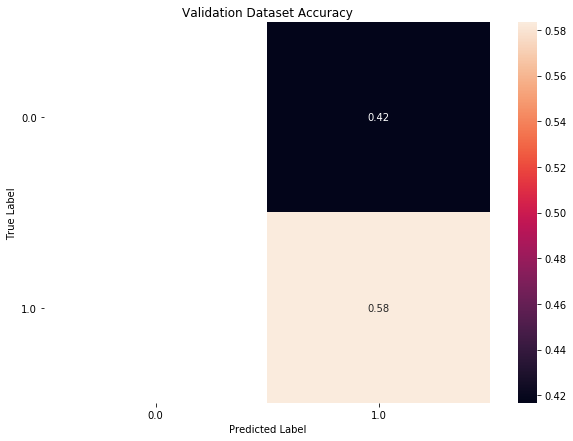

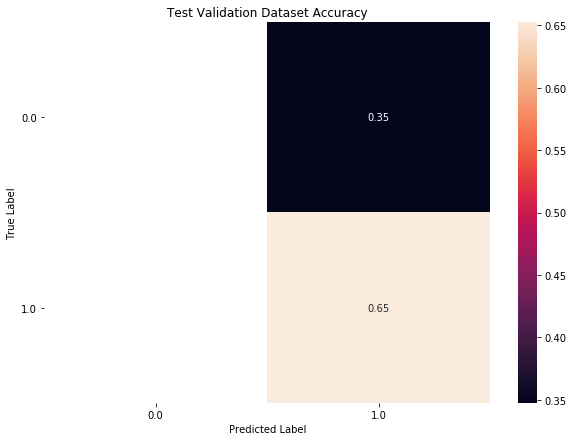

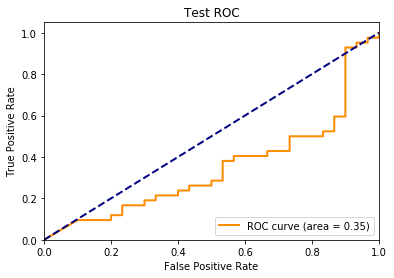

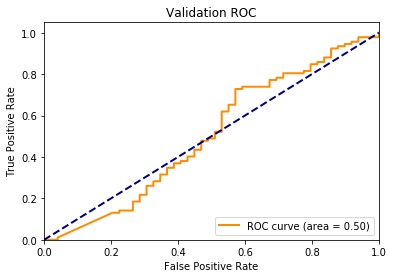

Presenting Results for: 11/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.5, 'dense_dropout_p': 0.5, 'activation': 'relu', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f8c80bd6cd0>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.7226 - accuracy: 0.5363 - precision_10: 0.5363 - recall_10: 0.5363 - val_loss: 0.6877 - val_accuracy: 0.6525 - val_precision_10: 0.6525 - val_recall_10: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7261 - accuracy: 0.4813 - precision_10: 0.4813 - recall_10: 0.4813 - val_loss: 0.6800 - val_accuracy: 0.6525 - val_precision_10: 0.6525 - val_recall_10: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7211 - accuracy: 0.5010 - precision_10: 0.5010 - recall_10: 0.5010 - val_loss: 0.6779 - val_accuracy: 0.6525 - val_precision_10: 0.6525 - val_recall_

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


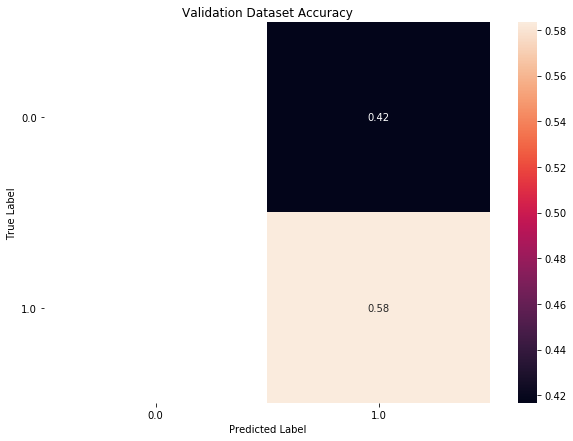

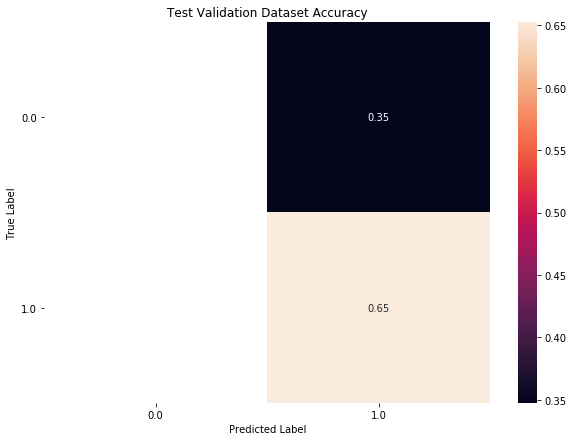

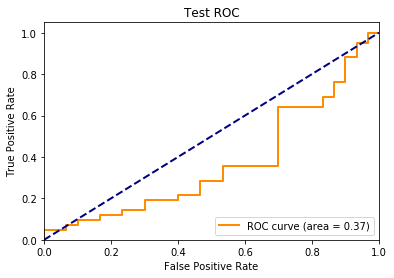

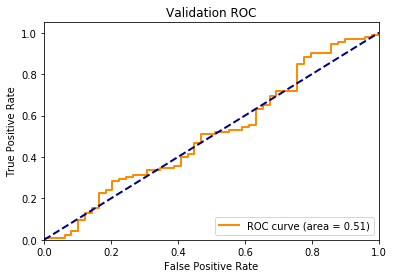

Presenting Results for: 12/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.2, 'dense_dropout_p': None, 'activation': 'tanh', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.7510 - accuracy: 0.4519 - precision_11: 0.4519 - recall_11: 0.4519 - val_loss: 0.7210 - val_accuracy: 0.3475 - val_precision_11: 0.3475 - val_recall_11: 0.3475
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7461 - accuracy: 0.4519 - precision_11: 0.4519 - recall_11: 0.4519 - val_loss: 0.7221 - val_accuracy: 0.3475 - val_precision_11: 0.3475 - val_recall_11: 0.3475
Epoch 3/2000
32/32 [==============================] - 0s 1ms/step - loss: 0.7402 - accuracy: 0.4519 - precision_11: 0.4519 - recall_11: 0.4519 - val_loss: 0.7231 - val_accuracy: 0.3475 - val_precision_11: 0.3475 -

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


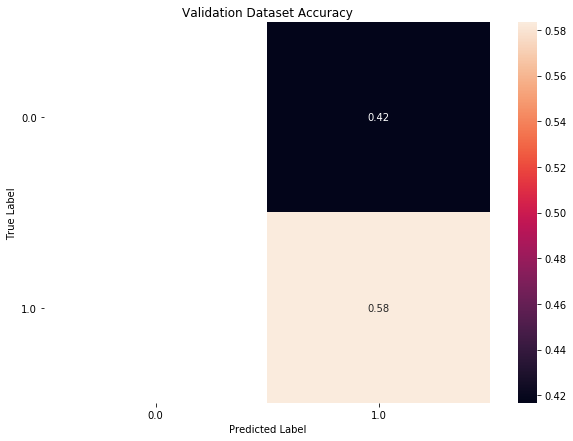

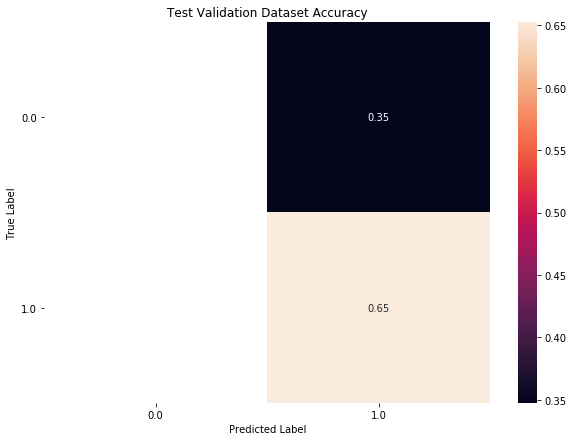

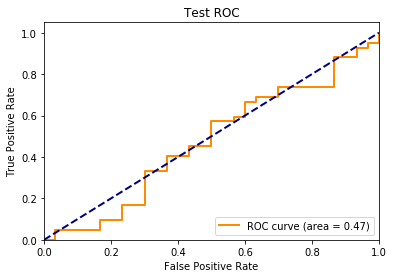

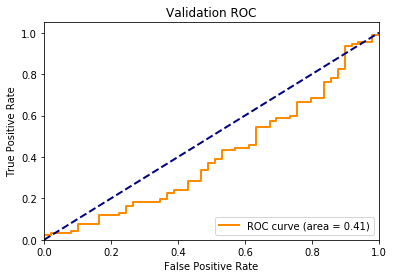

Presenting Results for: 13/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': None, 'dense_dropout_p': 0.2, 'activation': 'relu', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.6950 - accuracy: 0.5462 - precision_12: 0.5462 - recall_12: 0.5462 - val_loss: 0.6852 - val_accuracy: 0.6525 - val_precision_12: 0.6525 - val_recall_12: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.5501 - precision_12: 0.5501 - recall_12: 0.5501 - val_loss: 0.6862 - val_accuracy: 0.6525 - val_precision_12: 0.6525 - val_recall_12: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 1ms/step - loss: 0.6980 - accuracy: 0.5403 - precision_12: 0.5403 - recall_12: 0.5403 - val_loss: 0.6867 - val_accuracy: 0.6525 - val_precision_12: 0.6525 -

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


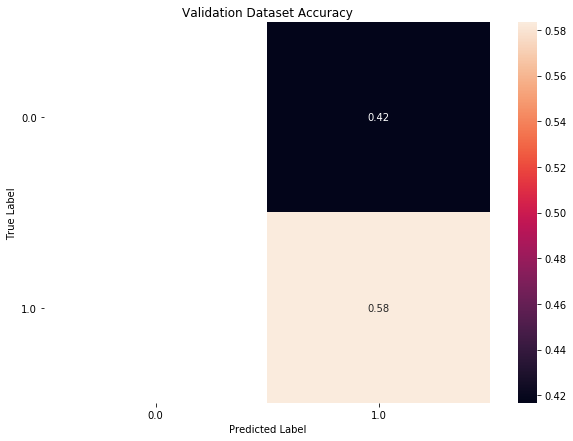

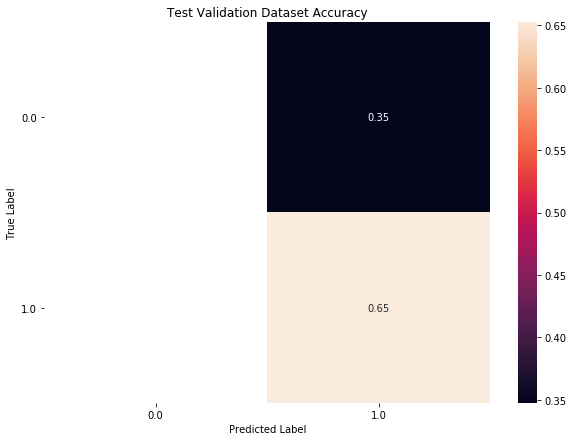

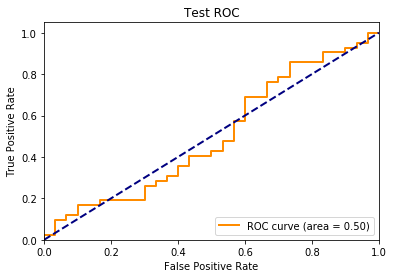

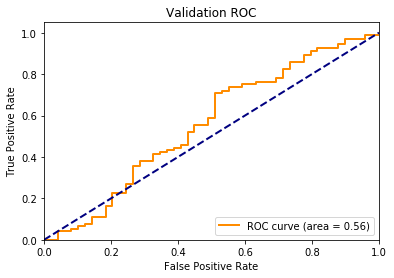

Presenting Results for: 14/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': None, 'dense_dropout_p': 0.5, 'activation': 'tanh', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.7250 - accuracy: 0.4892 - precision_13: 0.4882 - recall_13: 0.4872 - val_loss: 0.7018 - val_accuracy: 0.3475 - val_precision_13: 0.3475 - val_recall_13: 0.3475
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7264 - accuracy: 0.4951 - precision_13: 0.4951 - recall_13: 0.4951 - val_loss: 0.6992 - val_accuracy: 0.3475 - val_precision_13: 0.3475 - val_recall_13: 0.3475
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7252 - accuracy: 0.4931 - precision_13: 0.4931 - recall_13: 0.4931 - val_loss: 0.6971 - val_accuracy: 0.3475 - val_precision_13: 0.3475 -

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


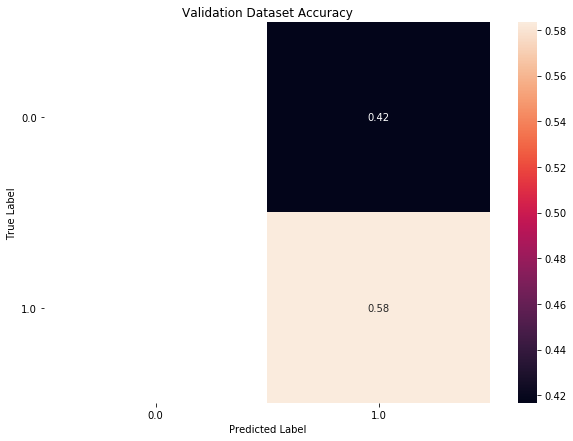

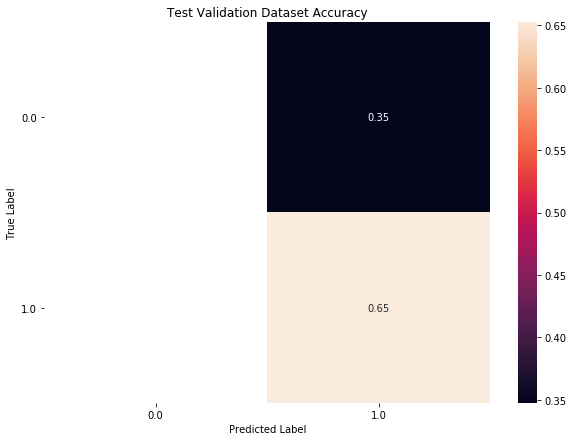

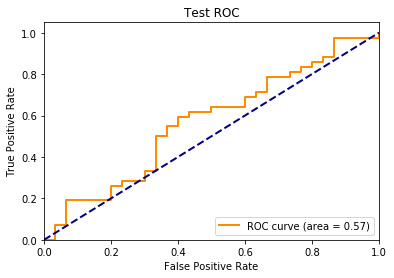

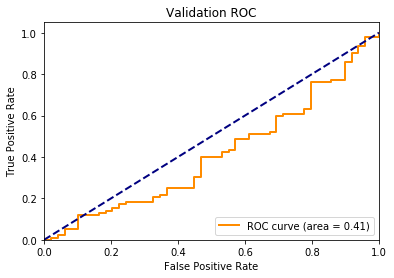

Presenting Results for: 15/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.5, 'dense_dropout_p': 0.5, 'activation': 'tanh', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f8c80bd6cd0>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.7621 - accuracy: 0.5167 - precision_14: 0.5167 - recall_14: 0.5167 - val_loss: 0.6822 - val_accuracy: 0.6525 - val_precision_14: 0.6525 - val_recall_14: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7117 - accuracy: 0.5285 - precision_14: 0.5285 - recall_14: 0.5285 - val_loss: 0.6827 - val_accuracy: 0.6525 - val_precision_14: 0.6525 - val_recall_14: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7179 - accuracy: 0.4971 - precision_14: 0.4971 - recall_14: 0.4971 - val_loss: 0.6794 - val_accuracy: 0.6525 - val_precision_14: 0.6525 - val_recall_

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


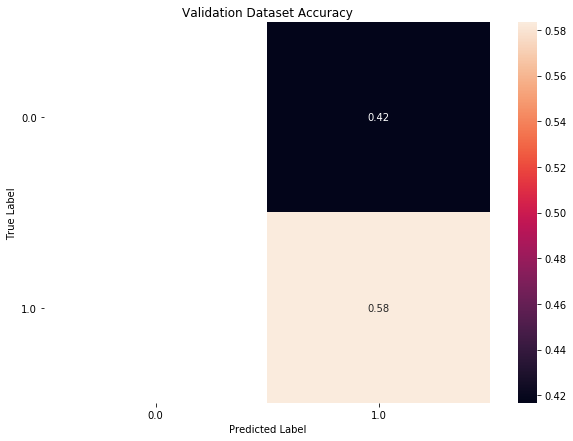

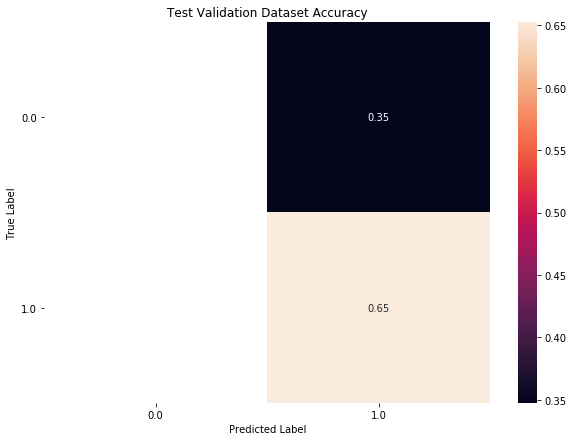

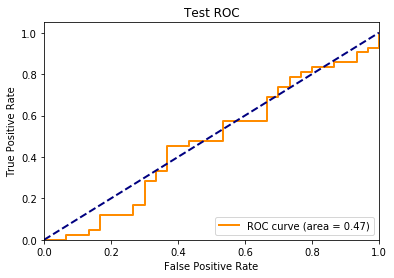

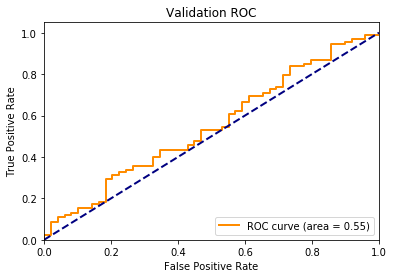

Presenting Results for: 16/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.2, 'dense_dropout_p': 0.5, 'activation': 'relu', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.7258 - accuracy: 0.5187 - precision_15: 0.5178 - recall_15: 0.5147 - val_loss: 0.6927 - val_accuracy: 0.6525 - val_precision_15: 0.6525 - val_recall_15: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7193 - accuracy: 0.5265 - precision_15: 0.5265 - recall_15: 0.5265 - val_loss: 0.6930 - val_accuracy: 0.6525 - val_precision_15: 0.6525 - val_recall_15: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7123 - accuracy: 0.5246 - precision_15: 0.5246 - recall_15: 0.5246 - val_loss: 0.6931 - val_accuracy: 0.6525 - val_precision_15: 0.6525 - 

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


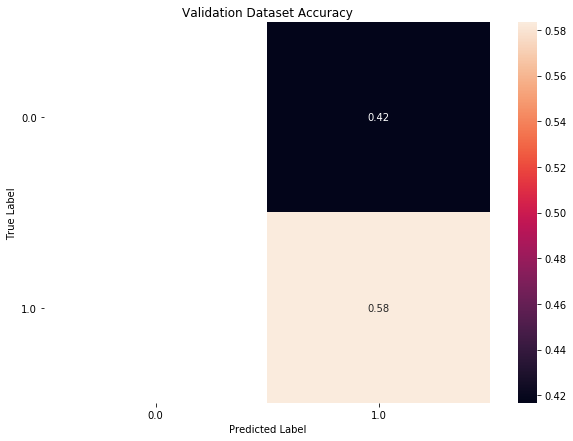

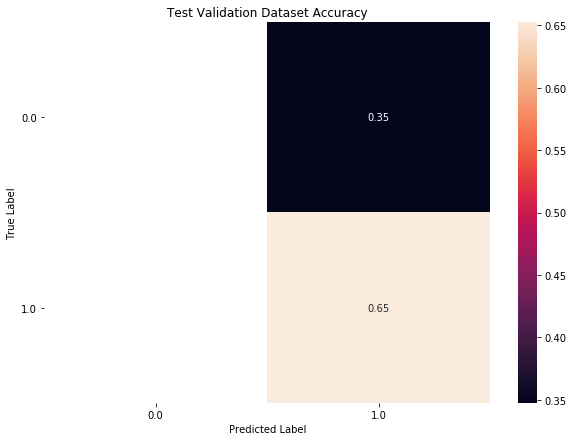

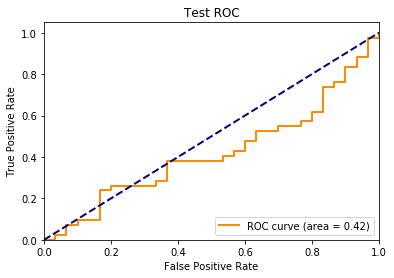

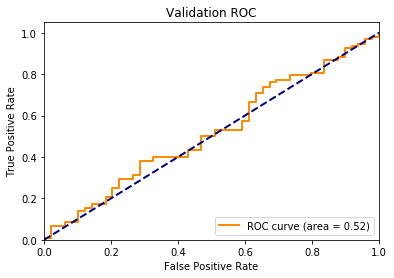

Presenting Results for: 17/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': None, 'dense_dropout_p': 0.2, 'activation': 'relu', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f8c80bd6cd0>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.6910 - accuracy: 0.5481 - precision_16: 0.5481 - recall_16: 0.5481 - val_loss: 0.6850 - val_accuracy: 0.6525 - val_precision_16: 0.6525 - val_recall_16: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.6953 - accuracy: 0.5147 - precision_16: 0.5147 - recall_16: 0.5147 - val_loss: 0.6897 - val_accuracy: 0.6525 - val_precision_16: 0.6525 - val_recall_16: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.5501 - precision_16: 0.5501 - recall_16: 0.5501 - val_loss: 0.6872 - val_accuracy: 0.6525 - val_precision_16: 0.6525 - val_recall

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


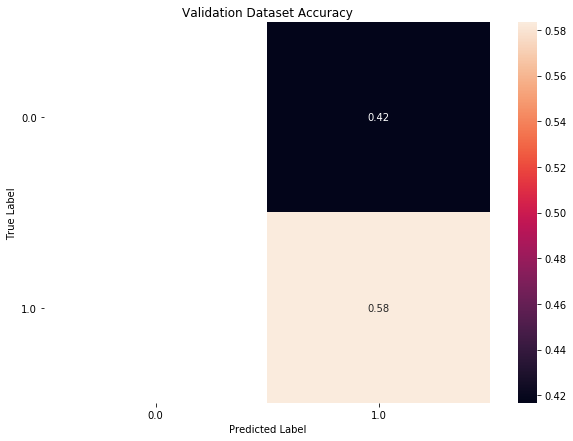

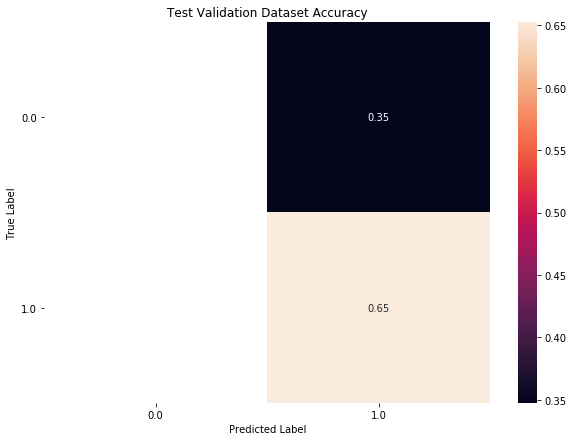

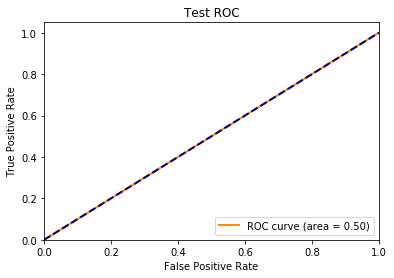

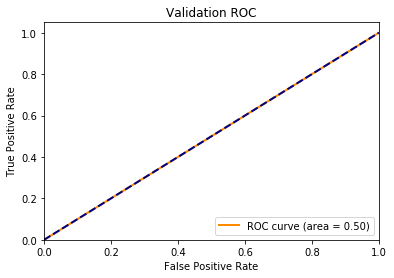

Presenting Results for: 18/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.5, 'dense_dropout_p': None, 'activation': 'tanh', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.6988 - accuracy: 0.5344 - precision_17: 0.5344 - recall_17: 0.5344 - val_loss: 0.6846 - val_accuracy: 0.6525 - val_precision_17: 0.6525 - val_recall_17: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.5285 - precision_17: 0.5285 - recall_17: 0.5285 - val_loss: 0.6833 - val_accuracy: 0.6525 - val_precision_17: 0.6525 - val_recall_17: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5580 - precision_17: 0.5580 - recall_17: 0.5580 - val_loss: 0.6820 - val_accuracy: 0.6525 - val_precision_17: 0.6525 -

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


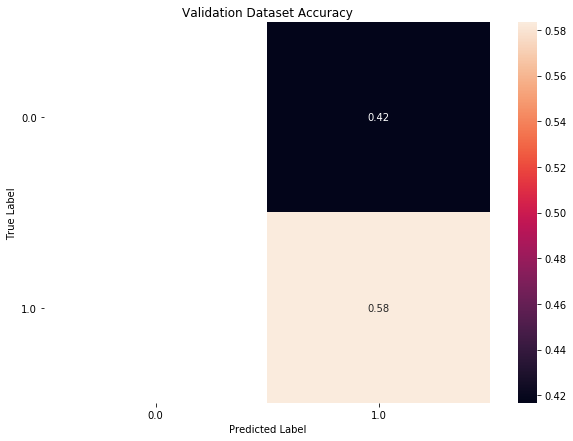

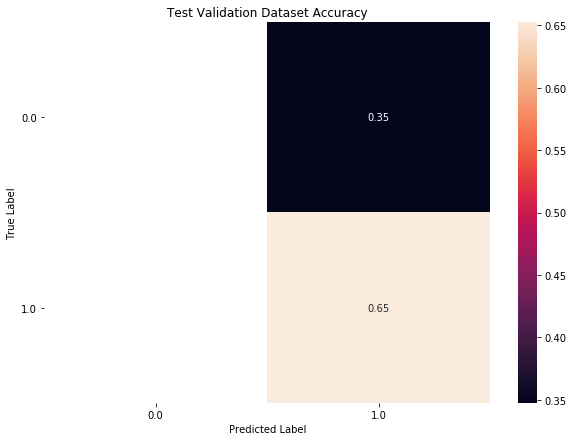

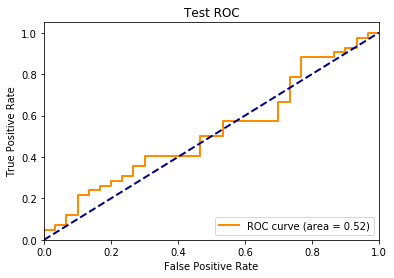

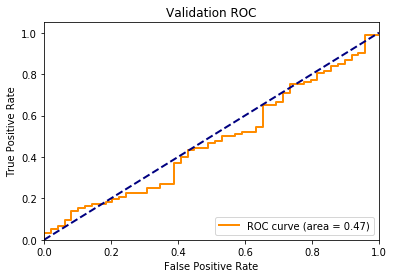

Presenting Results for: 19/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': None, 'dense_dropout_p': 0.2, 'activation': 'tanh', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.7175 - accuracy: 0.4401 - precision_18: 0.4401 - recall_18: 0.4401 - val_loss: 0.7026 - val_accuracy: 0.3475 - val_precision_18: 0.3475 - val_recall_18: 0.3475
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7113 - accuracy: 0.4754 - precision_18: 0.4754 - recall_18: 0.4754 - val_loss: 0.7000 - val_accuracy: 0.3475 - val_precision_18: 0.3475 - val_recall_18: 0.3475
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7055 - accuracy: 0.4813 - precision_18: 0.4813 - recall_18: 0.4813 - val_loss: 0.6977 - val_accuracy: 0.3475 - val_precision_18: 0.3475 -

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


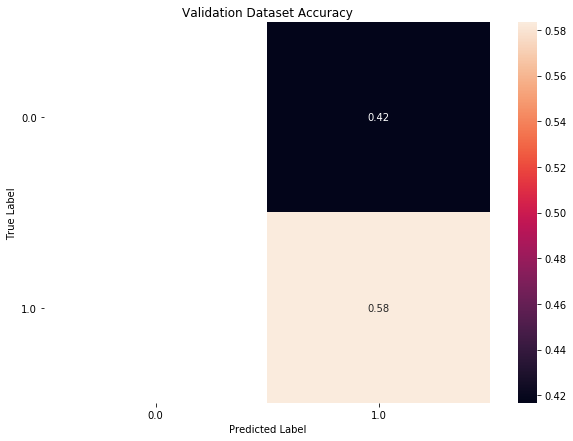

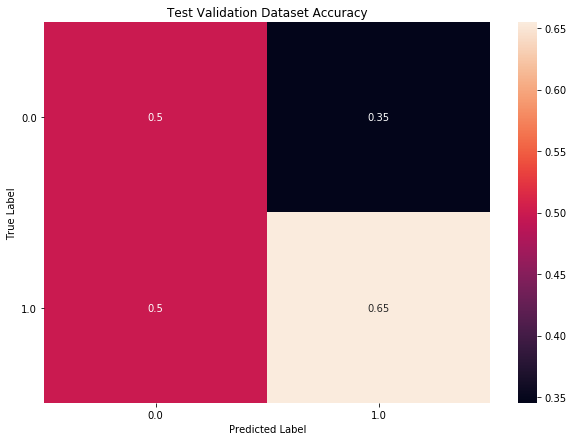

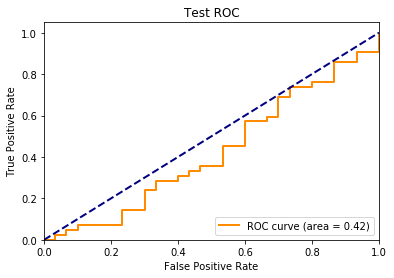

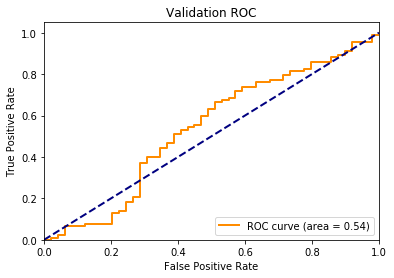

Presenting Results for: 20/20 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.5, 'dense_dropout_p': 0.2, 'activation': 'relu', 'n_dense_layers': 1, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 16, 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f8c80b8a090>}
Epoch 1/2000
32/32 [==============================] - 1s 9ms/step - loss: 0.7031 - accuracy: 0.5383 - precision_19: 0.5383 - recall_19: 0.5383 - val_loss: 0.6870 - val_accuracy: 0.6525 - val_precision_19: 0.6525 - val_recall_19: 0.6525
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.7047 - accuracy: 0.5226 - precision_19: 0.5226 - recall_19: 0.5226 - val_loss: 0.6902 - val_accuracy: 0.6525 - val_precision_19: 0.6525 - val_recall_19: 0.6525
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 0.6963 - accuracy: 0.5147 - precision_19: 0.5147 - recall_19: 0.5147 - val_loss: 0.6907 - val_accuracy: 0.6525 - val_precision_19: 0.6525 - 

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in true_divide


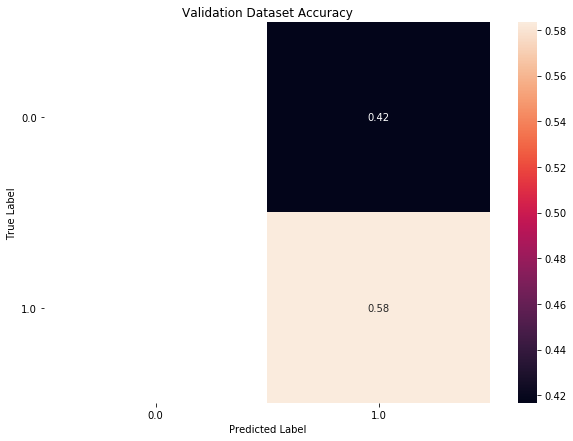

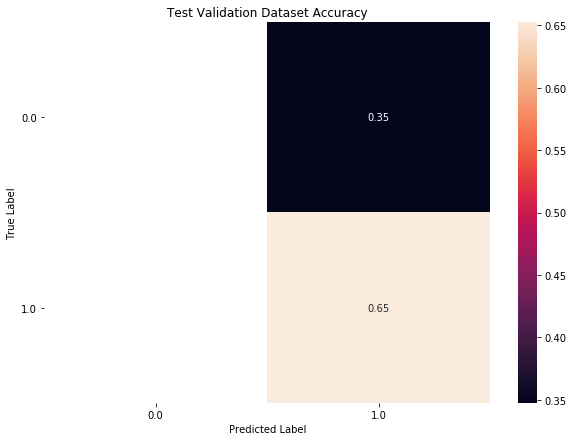

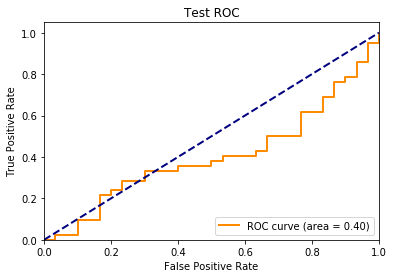

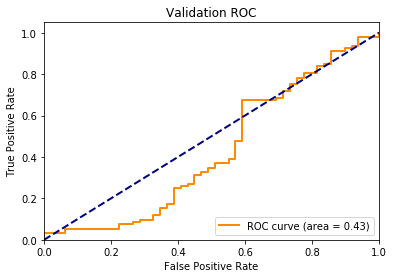

In [3]:
max_epochs = 2000
n_random_search = 20

batch_size = [16]
n_layers = [1] 
cnn_dropout_p = [None, 0.2, 0.5]
dense_dropout_p = [None, 0.2, 0.5]
activation = ['tanh','relu']
n_dense_layers = [1]
n_dense_neurons = [100]
batch_normalization = [True]
optimizer = [Adam(learning_rate=0.001, clipvalue=0.5), SGD(0.001)]

model_gs_params = list(itertools.product(*[n_layers, cnn_dropout_p, dense_dropout_p, activation, n_dense_layers, n_dense_neurons, batch_normalization, batch_size, optimizer]))
model_randomgs_params = random.sample(model_gs_params, n_random_search) if len(model_gs_params) > n_random_search else model_gs_params
print("%s Hyperparameter combinations determined" % len(model_randomgs_params))

training = PerformTraining(max_epochs, TRAIN_DATA_PATH, INTERM_DIR, MODEL_DIR,
                           model_randomgs_params, 'tcn', flush=True, save_plot=True)

In [7]:
pkl_name = os.path.join(MODEL_DIR, 'tcn', 'gs_res.pkl')
with open(pkl_name, 'rb') as f:
    tcn_gs_res = pkl.load(f)
    
te_acc = [sum(x[-3]) for x in tcn_gs_res]
max_acc = max(te_acc)
max_index = te_acc.index(max_acc)

tcn_gs_res[max_index]

[{'n_layers': 1,
  'cnn_dropout_p': None,
  'dense_dropout_p': 0.2,
  'activation': 'tanh',
  'n_dense_layers': 1,
  'n_dense_neurons': 100,
  'batch_normalization': True,
  'batch_size': 16,
  'learning_rate': 0.001},
 'tcn',
 array([       nan, 0.58333333]),
 array([0.5       , 0.65467626]),
 0.4222222222222222,
 0.5368234250221827]

# LSTM

20 Hyperparameter combinations determined
The class distributions in the training set are: (array([0., 1.]), array([230, 279]))
The class distributions in the validation set are: (array([0., 1.]), array([49, 92]))
The class distributions in the test set are: (array([0., 1.]), array([30, 42]))
Presenting Results for: 1/20 Hyperparameter Combination
{'n_layers': 2, 'batch_size': 32, 'lstm_neurons': 500, 'n_dense_neurons': 1000, 'dropout': None, 'activation': 'tanh', 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f81f2abb250>}


/home/kamran/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (32, 10, 500)             1018000   
_________________________________________________________________
lstm_3 (LSTM)                (32, 500)                 2002000   
_________________________________________________________________
dense_2 (Dense)              (32, 1000)                501000    
_________________________________________________________________
dense_3 (Dense)              (32, 2)                   2002      
Total params: 3,523,002
Trainable params: 3,523,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
15/15 [==============================] - 5s 156ms/step - loss: 0.6954 - accuracy: 0.5146 - precision_1: 0.5146 - recall_1: 0.5146 - val_loss: 0.6906 - val_accuracy: 0.6484 - val_precision_1: 0.6484 - val_recall_1: 0.6484
Epoch 2/

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in true_divide


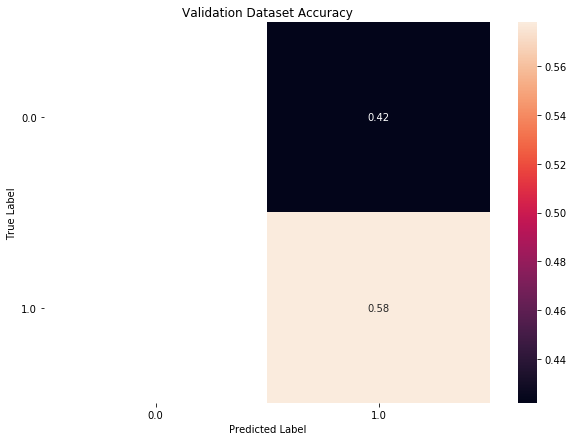

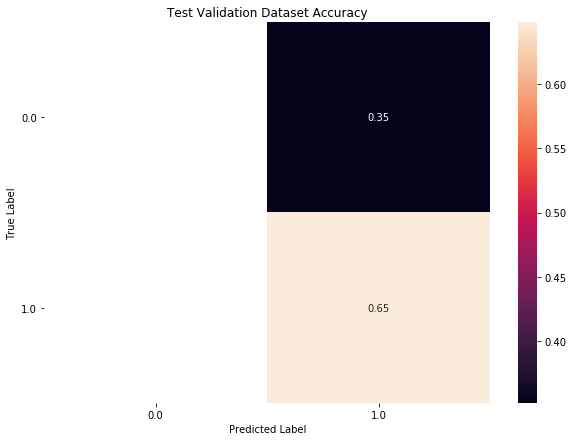

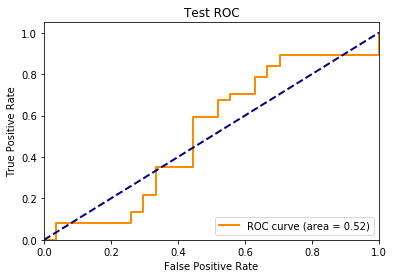

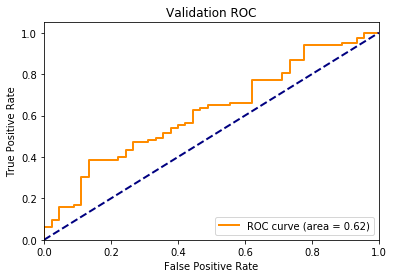

Presenting Results for: 2/20 Hyperparameter Combination
{'n_layers': 2, 'batch_size': 32, 'lstm_neurons': 100, 'n_dense_neurons': 1000, 'dropout': 0.2, 'activation': 'tanh', 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f81f2abb250>}


/home/kamran/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (32, 10, 100)             43600     
_________________________________________________________________
dropout (Dropout)            (32, 10, 100)             0         
_________________________________________________________________
lstm_5 (LSTM)                (32, 100)                 80400     
_________________________________________________________________
dropout_1 (Dropout)          (32, 100)                 0         
_________________________________________________________________
dense_4 (Dense)              (32, 1000)                101000    
_________________________________________________________________
dense_5 (Dense)              (32, 2)                   2002      
Total params: 227,002
Trainable params: 227,002
Non-trainable params: 0
________________________________________________

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in true_divide


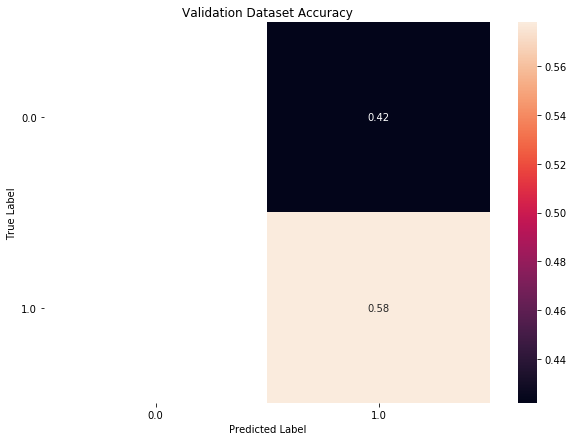

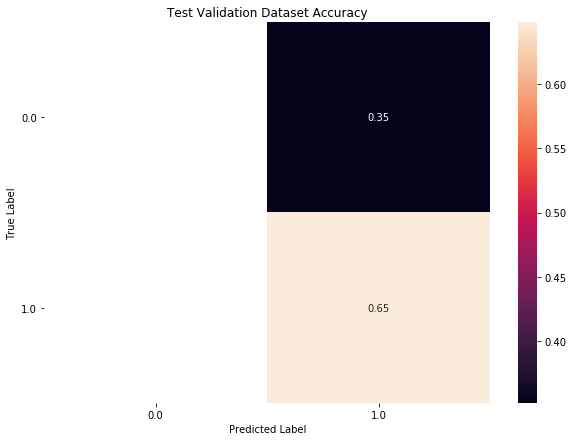

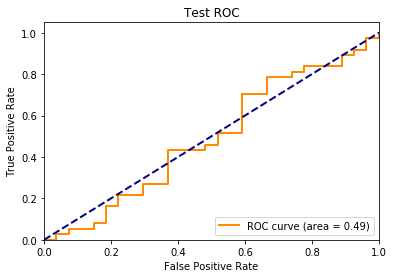

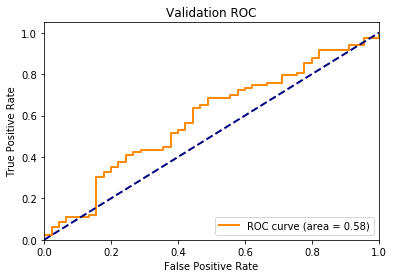

Presenting Results for: 3/20 Hyperparameter Combination
{'n_layers': 2, 'batch_size': 32, 'lstm_neurons': 1000, 'n_dense_neurons': 100, 'dropout': 0.2, 'activation': 'relu', 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f81dc14d2d0>}


/home/kamran/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (32, 10, 1000)            4036000   
_________________________________________________________________
dropout_2 (Dropout)          (32, 10, 1000)            0         
_________________________________________________________________
lstm_7 (LSTM)                (32, 1000)                8004000   
_________________________________________________________________
dropout_3 (Dropout)          (32, 1000)                0         
_________________________________________________________________
dense_6 (Dense)              (32, 100)                 100100    
_________________________________________________________________
dense_7 (Dense)              (32, 2)                   202       
Total params: 12,140,302
Trainable params: 12,140,302
Non-trainable params: 0
__________________________________________

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in true_divide


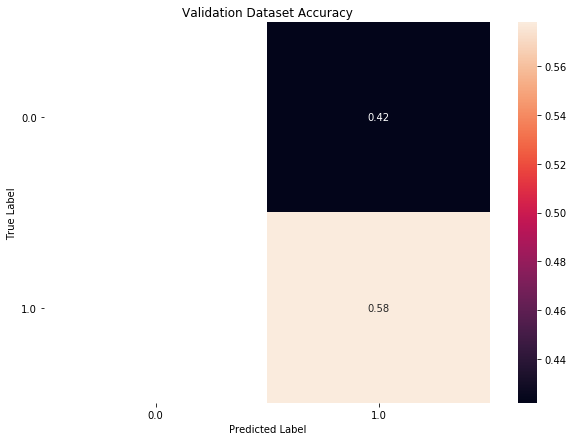

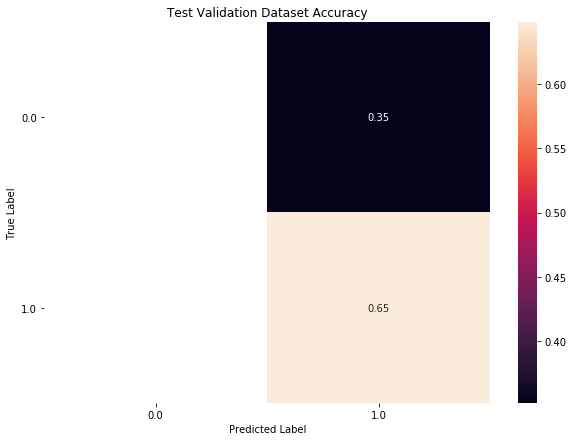

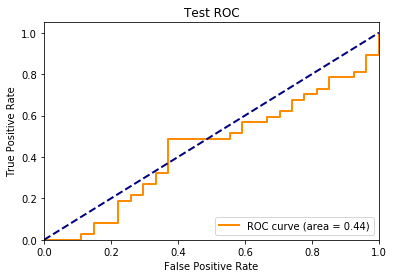

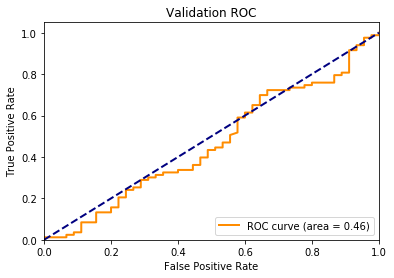

Presenting Results for: 4/20 Hyperparameter Combination
{'n_layers': 2, 'batch_size': 32, 'lstm_neurons': 100, 'n_dense_neurons': 100, 'dropout': 0.8, 'activation': 'relu', 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f81f2abb250>}


/home/kamran/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (32, 10, 100)             43600     
_________________________________________________________________
dropout_4 (Dropout)          (32, 10, 100)             0         
_________________________________________________________________
lstm_9 (LSTM)                (32, 100)                 80400     
_________________________________________________________________
dropout_5 (Dropout)          (32, 100)                 0         
_________________________________________________________________
dense_8 (Dense)              (32, 100)                 10100     
_________________________________________________________________
dense_9 (Dense)              (32, 2)                   202       
Total params: 134,302
Trainable params: 134,302
Non-trainable params: 0
________________________________________________

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in true_divide
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in true_divide


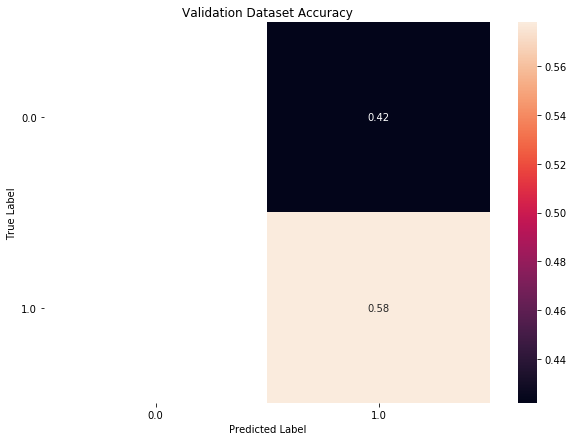

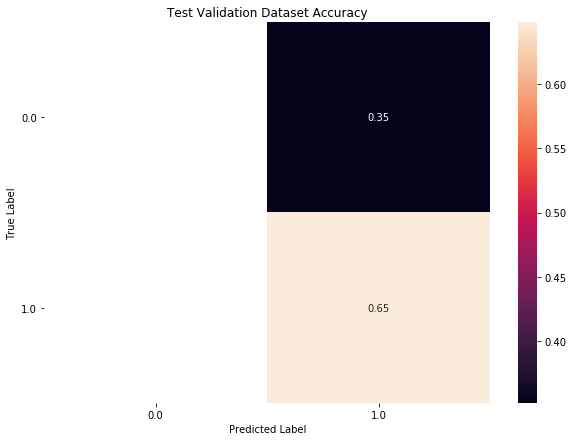

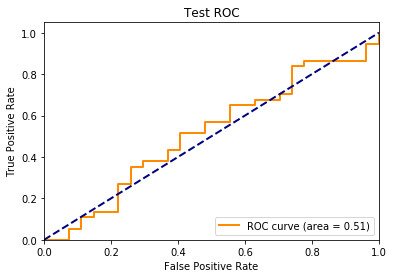

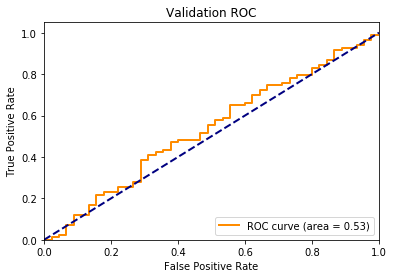

Presenting Results for: 5/20 Hyperparameter Combination
{'n_layers': 2, 'batch_size': 32, 'lstm_neurons': 100, 'n_dense_neurons': 500, 'dropout': None, 'activation': 'tanh', 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7f81f2abb250>}


/home/kamran/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (32, 10, 100)             43600     
_________________________________________________________________
lstm_11 (LSTM)               (32, 100)                 80400     
_________________________________________________________________
dense_10 (Dense)             (32, 500)                 50500     
_________________________________________________________________
dense_11 (Dense)             (32, 2)                   1002      
Total params: 175,502
Trainable params: 175,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
15/15 [==============================] - 4s 69ms/step - loss: 0.6913 - accuracy: 0.5146 - precision_5: 0.5146 - recall_5: 0.5146 - val_loss: 0.6627 - val_accuracy: 0.6484 - val_precision_5: 0.6484 - val_recall_5: 0.6484
Epoch 2/2000


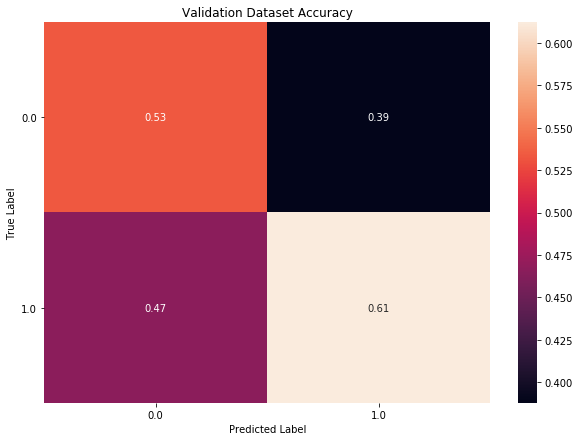

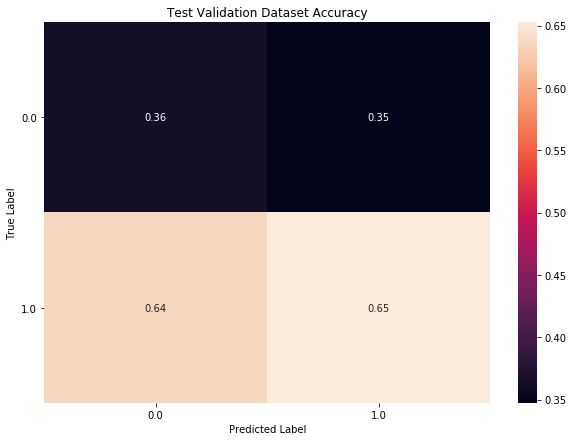

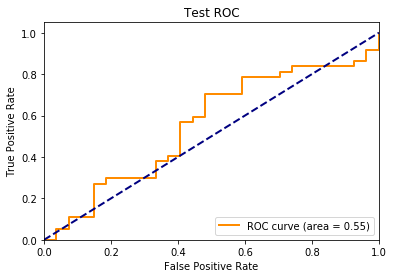

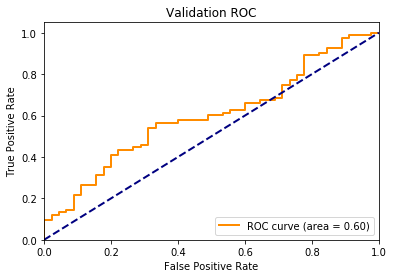

Presenting Results for: 6/20 Hyperparameter Combination
{'n_layers': 2, 'batch_size': 32, 'lstm_neurons': 1000, 'n_dense_neurons': 1000, 'dropout': 0.5, 'activation': 'relu', 'optimizer': <keras.optimizer_v2.gradient_descent.SGD object at 0x7f81dc14d2d0>}


/home/kamran/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (32, 10, 1000)            4036000   
_________________________________________________________________
dropout_6 (Dropout)          (32, 10, 1000)            0         
_________________________________________________________________
lstm_13 (LSTM)               (32, 1000)                8004000   
_________________________________________________________________
dropout_7 (Dropout)          (32, 1000)                0         
_________________________________________________________________
dense_12 (Dense)             (32, 1000)                1001000   
_________________________________________________________________
dense_13 (Dense)             (32, 2)                   2002      
Total params: 13,043,002
Trainable params: 13,043,002
Non-trainable params: 0
__________________________________________

KeyboardInterrupt: 

In [4]:
max_epochs = 2000
n_random_search = 20

n_layers = [2]
batch_size = [32]
lstm_neurons = [100, 500, 1000]
n_dense_neurons = [100, 500, 1000]
dropout = [None, 0.2, 0.5, 0.8]
activation = ['relu','tanh']
optimizer = [Adam(learning_rate=0.001, clipvalue=0.5), SGD(learning_rate=0.001)]
#optimizer = []

model_gs_params = list(itertools.product(*[n_layers, batch_size, lstm_neurons, n_dense_neurons, dropout, activation, optimizer]))
model_randomgs_params = random.sample(model_gs_params, n_random_search) if len(model_gs_params) > n_random_search else model_gs_params
model_gs_params = model_gs_params[7:]
print("%s Hyperparameter combinations determined" % len(model_randomgs_params))

training = PerformTraining(max_epochs, TRAIN_DATA_PATH, INTERM_DIR, MODEL_DIR,
                           model_randomgs_params, 'lstm', flush=False, save_plot=True)